In [5]:
!pip install textblob
!python -m textblob.download_corpora


                                              0.0/624.3 kB ? eta -:--:--
     -----                                   92.2/624.3 kB 2.6 MB/s eta 0:00:01
     ------------------------               409.6/624.3 kB 4.2 MB/s eta 0:00:01
     -------------------------------------- 624.3/624.3 kB 4.9 MB/s eta 0:00:00
                                              0.0/1.5 MB ? eta -:--:--
     -------------                            0.5/1.5 MB 16.2 MB/s eta 0:00:01
     --------------------------------         1.2/1.5 MB 15.6 MB/s eta 0:00:01
     ---------------------------------------  1.5/1.5 MB 15.9 MB/s eta 0:00:01
     ---------------------------------------- 1.5/1.5 MB 12.0 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
Finished.


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\FAIZA\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\FAIZA\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\FAIZA\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\FAIZA\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\FAIZA\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\conll2000.zip.
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\FAIZA\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\movie_reviews.zip.


In [ ]:
import pandas as pd
from textblob import TextBlob
from tqdm import tqdm

# Load IMDb dataset (adjust path if needed)
df = pd.read_csv("C:/Users/FAIZA/Downloads/archive/IMDB Dataset.csv")

# Define a function to classify sentiment using TextBlob
def classify_sentiment(text):
    analysis = TextBlob(text).sentiment.polarity  # Get polarity score (-1 to 1)
    if analysis > 0.2:
        return "positive"  # Positive sentiment
    elif analysis < -0.2:
        return "negative"  # Negative sentiment
    else:
        return "neutral"  # Newly added class

# Apply classification to all reviews
tqdm.pandas()  # Enable progress bar for large datasets
df["sentiment"] = df["review"].progress_apply(classify_sentiment)

# Convert labels to numeric format
df["label"] = df["sentiment"].map({"negative": 0, "neutral": 1, "positive": 2})

# Print new label distribution
print("Class Distribution after relabeling:")
print(df["label"].value_counts())

# Save the new dataset
df.to_csv("IMDB_Multiclass_Dataset.csv", index=False)
print("✅ Saved the modified dataset with neutral sentiment!")


100%|██████████| 50000/50000 [02:07<00:00, 392.78it/s]


Class Distribution after relabeling:
1    35448
2    12845
0     1707
Name: label, dtype: int64
✅ Saved the modified dataset with neutral sentiment!


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [9]:
# Load IMDb dataset (after adding neutral sentiment)
df = pd.read_csv("IMDB_Multiclass_Dataset.csv")

In [52]:
# Check dataset structure
print(df.head())
print("Class Distribution:")
print(df['sentiment'].value_counts())

                                              review sentiment  label
0  One of the other reviewers has mentioned that ...   neutral      1
1  A wonderful little production. <br /><br />The...   neutral      1
2  I thought this was a wonderful way to spend ti...  positive      2
3  Basically there's a family where a little boy ...   neutral      1
4  Petter Mattei's "Love in the Time of Money" is...  positive      2
Class Distribution:
neutral     35448
positive    12845
negative     1707
Name: sentiment, dtype: int64


In [53]:
# Convert labels to numerical values (0=Negative, 1=Neutral, 2=Positive)
label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df['sentiment'] = df['sentiment'].map(label_mapping)

In [54]:
# Text Vectorization using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X = vectorizer.fit_transform(df['review'])
y = df['label']

In [56]:
# Split dataset into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [57]:
# Train Multinomial Naïve Bayes Model
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
mnb_preds = mnb.predict(X_test)

In [58]:
# Train Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

In [59]:
# Convert labels to One-Hot Encoding for AUC calculation
encoder = OneHotEncoder(sparse_output=False)
y_test_encoded = encoder.fit_transform(np.array(y_test).reshape(-1, 1))

In [60]:
# Define evaluation function
def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"\n📊 Model Performance: {model_name}\n")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall:", recall_score(y_true, y_pred, average='weighted'))
    print("F1-score:", f1_score(y_true, y_pred, average='weighted'))
    auc_score = roc_auc_score(y_test_encoded, y_proba, average='weighted', multi_class='ovr')
    print("AUC:", auc_score)

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


📊 Model Performance: Multinomial Naïve Bayes

Accuracy: 0.7651
Precision: 0.7466736218710632
Recall: 0.7651
F1-score: 0.7158768505414106
AUC: 0.501472454608342


c:\Users\FAIZA\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


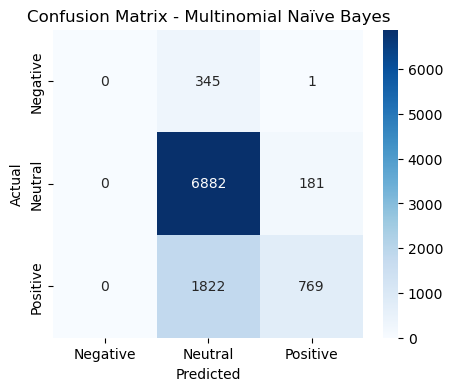


📊 Model Performance: Random Forest

Accuracy: 0.7937
Precision: 0.8098802130555826
Recall: 0.7937
F1-score: 0.7577803359595778
AUC: 0.5053863376588119


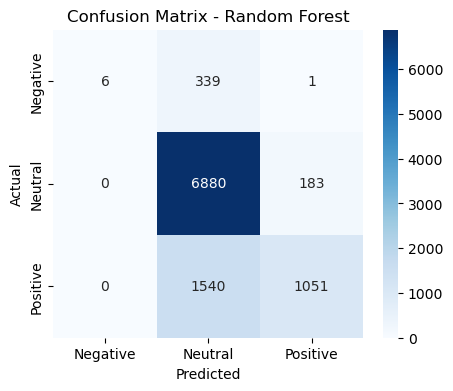

In [61]:
# Evaluate both models
evaluate_model(y_test, mnb_preds, mnb_proba, "Multinomial Naïve Bayes")
evaluate_model(y_test, rf_preds, rf_proba, "Random Forest")